# Final Project: Used Car Price Predictor
### Author: Satish Agrawal, Sanjay Jaras

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import types
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import BayesianRidge
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Lasso

## Configurations


In [2]:
%matplotlib inline
plt.style.use("seaborn-darkgrid")
random_state = 17
np.random.seed(random_state)

## Load Data
Data downloaded from https://www.kaggle.com/austinreese/craigslist-carstrucks-data


In [3]:
org_df = pd.read_csv("vehicles.csv", index_col=[0], converters={"cylinders":str})

### Show summary

In [4]:
org_df.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,drive,size,type,paint_color,image_url,description,state,lat,long,posting_date
0,7240372487,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,35990,2010.0,chevrolet,corvette grand sport,good,8 cylinders,...,rwd,NaN,other,NaN,https://images.craigslist.org/00N0N_ipkbHVZYf4...,Carvana is the safer way to buy a car During t...,al,32.590000,-85.480000,2020-12-02T08:11:30-0600
1,7240309422,https://auburn.craigslist.org/cto/d/auburn-201...,auburn,https://auburn.craigslist.org,7500,2014.0,hyundai,sonata,excellent,4 cylinders,...,fwd,NaN,sedan,NaN,https://images.craigslist.org/00s0s_gBHYmJ5o7y...,I'll move to another city and try to sell my c...,al,32.547500,-85.468200,2020-12-02T02:11:50-0600
2,7240224296,https://auburn.craigslist.org/cto/d/auburn-200...,auburn,https://auburn.craigslist.org,4900,2006.0,bmw,x3 3.0i,good,6 cylinders,...,NaN,NaN,SUV,blue,https://images.craigslist.org/00B0B_5zgEGWPOrt...,Clean 2006 BMW X3 3.0I. Beautiful and rare Bl...,al,32.616807,-85.464149,2020-12-01T19:50:41-0600
3,7240103965,https://auburn.craigslist.org/cto/d/lanett-tru...,auburn,https://auburn.craigslist.org,2000,1974.0,chevrolet,c-10,good,4 cylinders,...,rwd,full-size,pickup,blue,https://images.craigslist.org/00M0M_6o7KcDpArw...,1974 chev. truck (LONG BED) NEW starter front ...,al,32.861600,-85.216100,2020-12-01T15:54:45-0600
4,7239983776,https://auburn.craigslist.org/cto/d/auburn-200...,auburn,https://auburn.craigslist.org,19500,2005.0,ford,f350 lariat,excellent,8 cylinders,...,4wd,full-size,pickup,blue,https://images.craigslist.org/00p0p_b95l1EgUfl...,2005 Ford F350 Lariat (Bullet Proofed). This t...,al,32.547500,-85.468200,2020-12-01T12:53:56-0600


### Show Original Data types

In [5]:
org_df.dtypes

id                int64
url              object
region           object
region_url       object
price             int64
year            float64
manufacturer     object
model            object
condition        object
cylinders        object
fuel             object
odometer        float64
title_status     object
transmission     object
VIN              object
drive            object
size             object
type             object
paint_color      object
image_url        object
description      object
state            object
lat             float64
long            float64
posting_date     object
dtype: object

### Let's drop column that we will not be using

In [6]:
#columns = ["region", "price", "year", "manufacturer", "model", "condition", "cylinders", "fuel", "odometer", "title_status", "transmission", 
#           "drive", "size", "type", "paint_color", "state", "lat", "long", "posting_date"]
#df_sel = org_df[columns]


### Consider dropping columns instead of subsetting for better clarity
df_sel = org_df.drop(columns=['url', 'id','image_url', 'description', 'region_url', 'VIN'])

# drop NA in important columns
#df_sel = org_df.dropna(subset=['year','condition','model','manufacturer'])

### Rename size column name to avoid keyword issue

In [7]:
df_sel.rename(columns={"size":"size_"}, inplace=True)

In [8]:
df_sel.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size_,type,paint_color,state,lat,long,posting_date
0,auburn,35990,2010.0,chevrolet,corvette grand sport,good,8 cylinders,gas,32742.0,clean,other,rwd,NaN,other,NaN,al,32.590000,-85.480000,2020-12-02T08:11:30-0600
1,auburn,7500,2014.0,hyundai,sonata,excellent,4 cylinders,gas,93600.0,clean,automatic,fwd,NaN,sedan,NaN,al,32.547500,-85.468200,2020-12-02T02:11:50-0600
2,auburn,4900,2006.0,bmw,x3 3.0i,good,6 cylinders,gas,87046.0,clean,automatic,NaN,NaN,SUV,blue,al,32.616807,-85.464149,2020-12-01T19:50:41-0600
3,auburn,2000,1974.0,chevrolet,c-10,good,4 cylinders,gas,190000.0,clean,automatic,rwd,full-size,pickup,blue,al,32.861600,-85.216100,2020-12-01T15:54:45-0600
4,auburn,19500,2005.0,ford,f350 lariat,excellent,8 cylinders,diesel,116000.0,lien,automatic,4wd,full-size,pickup,blue,al,32.547500,-85.468200,2020-12-01T12:53:56-0600


### Distribution and outlier for years

In [9]:
df_sel.year.describe()

count    457163.000000
mean       2010.746067
std           8.868136
min        1900.000000
25%        2008.000000
50%        2013.000000
75%        2016.000000
max        2021.000000
Name: year, dtype: float64

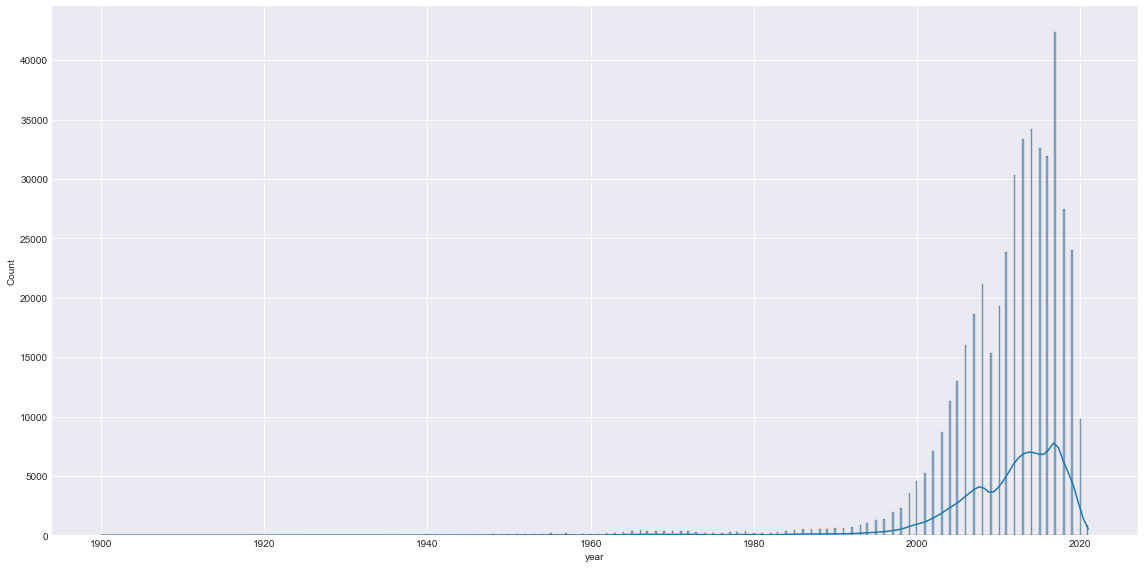

In [10]:
sns.displot(x=df_sel.year, kde=True, height=8, aspect=2 )
plt.show()

### Drop Records older than year 2000 and newer than 2020

In [11]:
df_sel = df_sel[(df_sel.year>1999) & (df_sel.year<2021)]

In [12]:
df_sel.year.describe()

count    430479.000000
mean       2012.289419
std           4.933574
min        2000.000000
25%        2009.000000
50%        2013.000000
75%        2016.000000
max        2020.000000
Name: year, dtype: float64

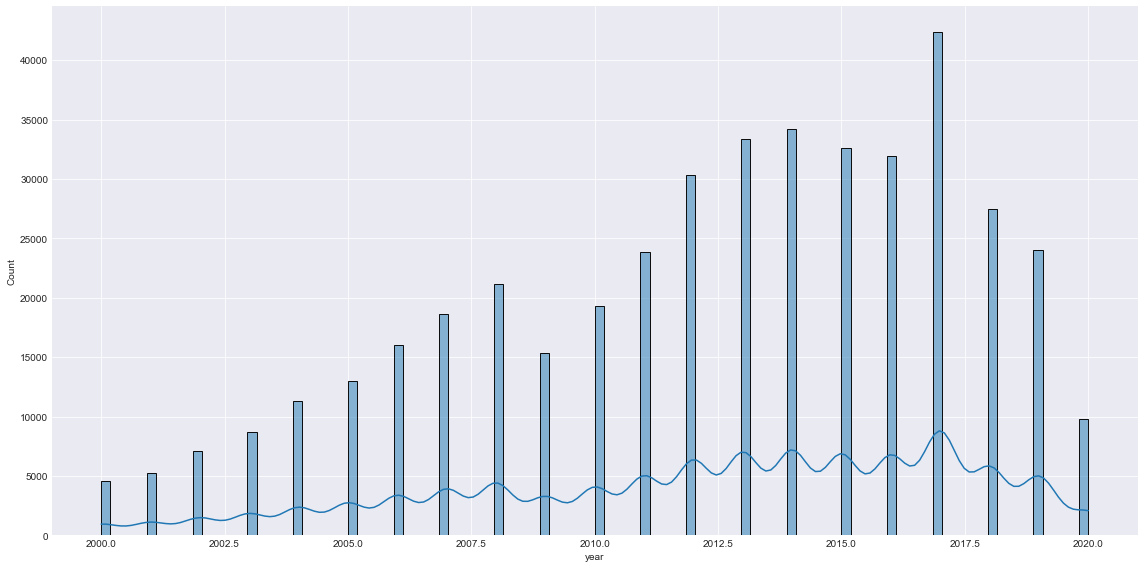

In [13]:
sns.displot(x=df_sel.year, kde=True, height=8, aspect=2 )
plt.show()

### Distribution and outlier for odometer

In [14]:
df_sel.odometer.describe()

count    3.831850e+05
mean     9.980204e+04
std      3.309354e+06
min      0.000000e+00
25%      4.065000e+04
50%      8.676400e+04
75%      1.324790e+05
max      2.043756e+09
Name: odometer, dtype: float64

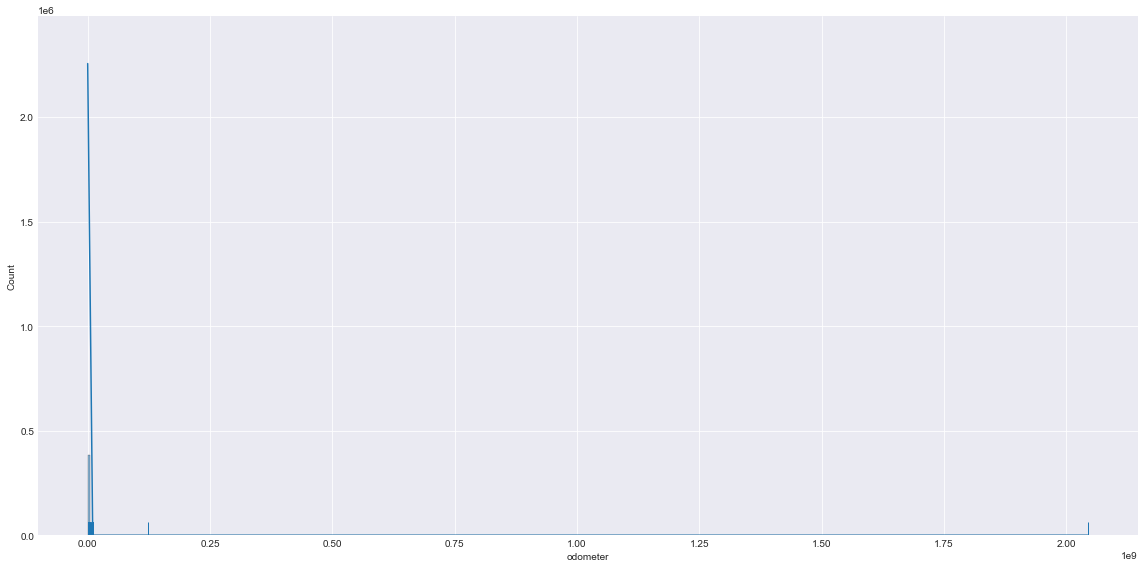

In [15]:
sns.displot(x=df_sel.odometer, kde=True, rug=True, height=8, bins=500, aspect=2 )
plt.show()

### Drop records with odometer greater than 200000

In [16]:
df_sel = df_sel[df_sel.odometer<200000]

In [17]:
df_sel.odometer.describe()

count    363802.000000
mean      84404.495583
std       52139.076062
min           0.000000
25%       38806.000000
50%       82077.500000
75%      124699.000000
max      199999.000000
Name: odometer, dtype: float64

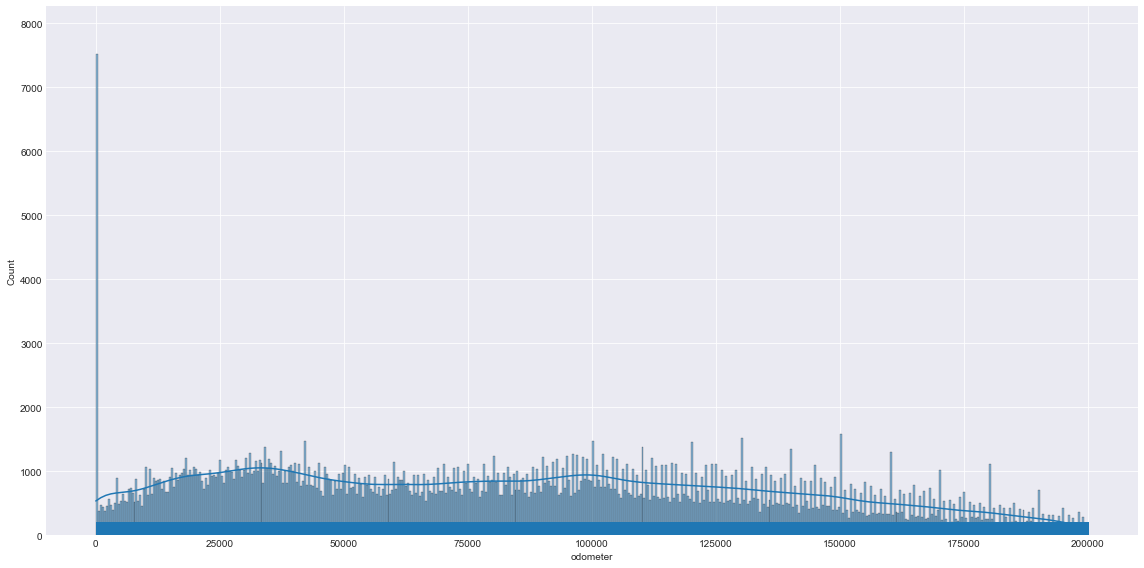

In [18]:
sns.displot(x=df_sel.odometer, kde=True, rug=True, height=8, bins=500, aspect=2 )
plt.show()

### Distribution and outlier for price

In [19]:
df_sel.price.describe()

count    3.638020e+05
mean     2.672375e+04
std      5.999674e+06
min      0.000000e+00
25%      5.990000e+03
50%      1.290000e+04
75%      2.300000e+04
max      3.615215e+09
Name: price, dtype: float64

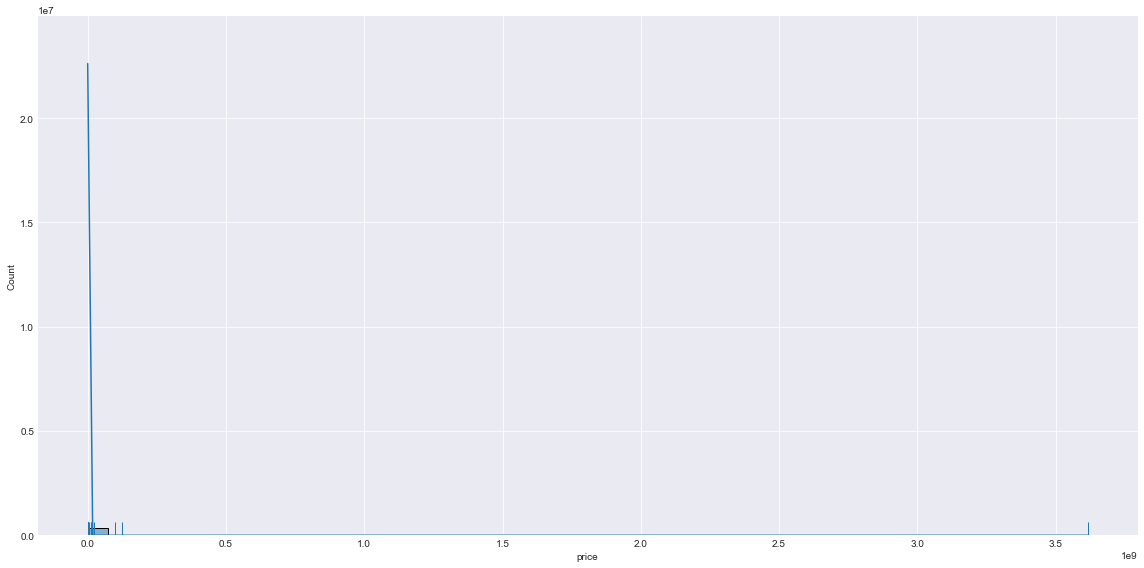

In [20]:
sns.displot(x=df_sel.price, kde=True, rug=True, height=8, bins=50, aspect=2 )
plt.show()

### Drop records with price greater than 300000

In [21]:
df_sel = df_sel[df_sel.price<300001]

In [22]:
df_sel.price.describe()

count    363782.000000
mean      16018.000547
std       14154.047114
min           0.000000
25%        5990.000000
50%       12900.000000
75%       23000.000000
max      299988.000000
Name: price, dtype: float64

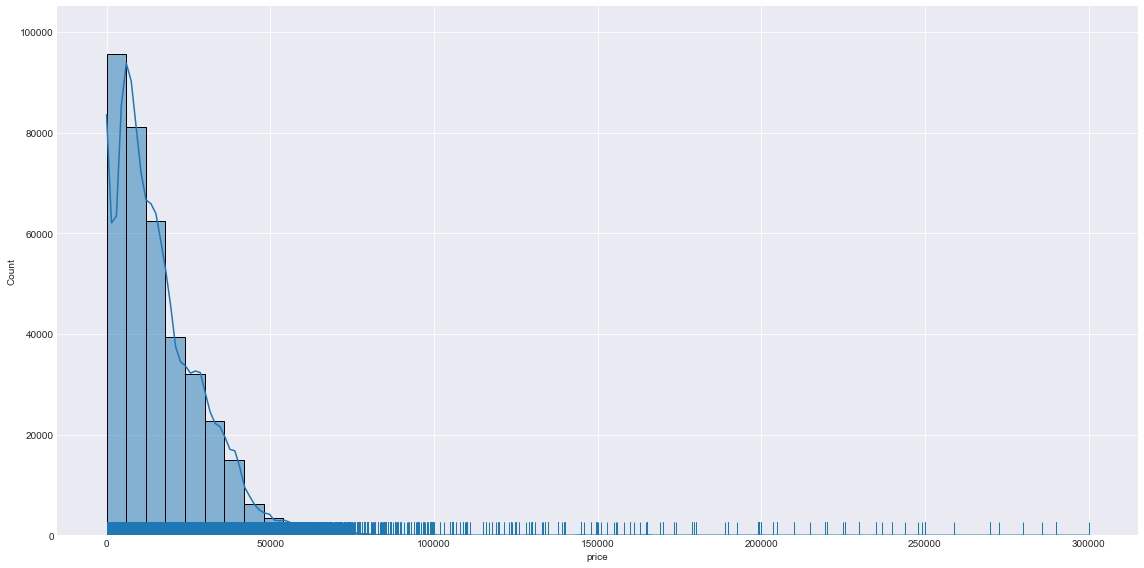

In [23]:
sns.displot(x=df_sel.price, kde=True, rug=True, height=8, bins=50, aspect=2 )
plt.show()

### Convert variables to appropriate data types

In [24]:
### Replace unknown and blank cylinder values with None

In [25]:
def replace_cylinders(x):
    
    if x == None or x.strip() == "" or x.strip() == "other":
        return None
    else: 
        return x.replace(" cylinders", "").strip()

### Need to replace "other" to something else from Cylinders
#df_sel.cylinders = df_sel.cylinders.apply(lambda x : replace_cylinders(x))

### Find Missing Values

In [26]:
df_sel.isnull().sum()

region               0
price                0
year                 0
manufacturer      9100
model             2062
condition       147846
cylinders            0
fuel              2303
odometer             0
title_status      1607
transmission      1580
drive            89340
size_           253811
type             64791
paint_color      93644
state                0
lat               6814
long              6814
posting_date         0
dtype: int64

<AxesSubplot:>

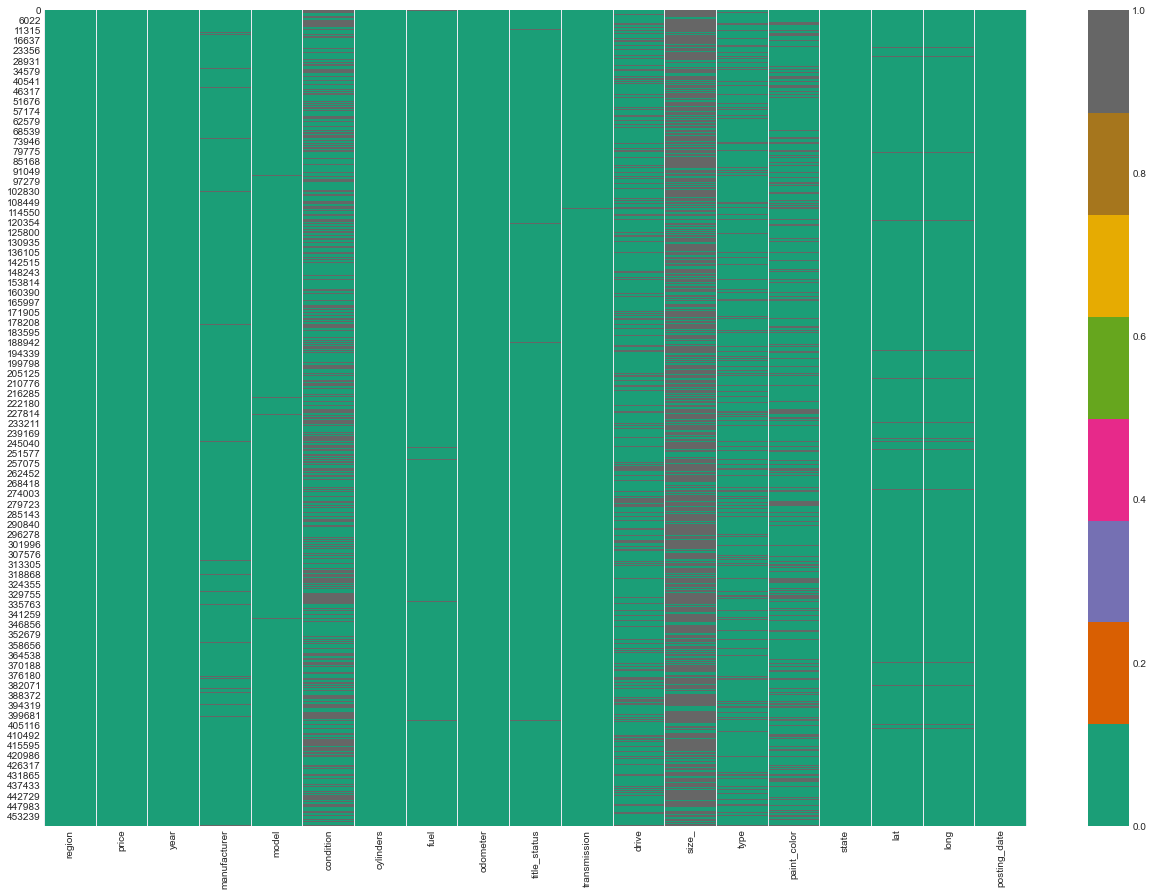

In [27]:
fig, ax =plt.subplots(1,figsize=(22, 15))
sns.heatmap(df_sel.isnull(), cmap="Dark2")

In [28]:
num_attr = ["year", "odometer", "lat", "long"]
cat_attr = ["region", "manufacturer", "model", "condition", "cylinders", "fuel", "title_status", "transmission", "drive", "size_", "paint_color", "state", "type"]

### Fill missing values wiht Imputers

#### Convert categorical features to numeric using Label Encoder

In [29]:
# move target variable to last
price_col = df_sel.price
df_sel = df_sel.drop(columns=["price"])
df_sel["price"] = price_col

# Copy Data frame for Imputaion estimation
df_imputer = df_sel.copy()
label_encoder = LabelEncoder()
def labelEncode(catFeature):
    nonulls = np.array(catFeature.dropna())
    impute_reshape = nonulls.reshape(-1,1)
    impute_ordinal = label_encoder.fit_transform(impute_reshape)
    catFeature.loc[catFeature.notnull()] = np.squeeze(impute_ordinal)
    return catFeature

for catFeature in cat_attr:
    labelEncode(df_imputer[catFeature])
    

/home/sanjay/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/sanjay/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [30]:
df_imputer.head()

,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size_,type,paint_color,state,lat,long,posting_date,price
0,16,2010.0,7,7795,2,7,2,32742.0,0,2,2,NaN,7,NaN,1,32.590000,-85.480000,2020-12-02T08:11:30-0600,35990
1,16,2014.0,17,19684,0,4,2,93600.0,0,0,1,NaN,9,NaN,1,32.547500,-85.468200,2020-12-02T02:11:50-0600,7500
2,16,2006.0,4,22466,2,6,2,87046.0,0,0,NaN,NaN,0,1,1,32.616807,-85.464149,2020-12-01T19:50:41-0600,4900
4,16,2005.0,12,11398,0,7,0,116000.0,1,0,0,1,8,1,1,32.547500,-85.468200,2020-12-01T12:53:56-0600,19500
5,16,2016.0,39,20505,2,6,2,33290.0,0,2,NaN,NaN,8,8,1,32.590000,-85.480000,2020-12-01T07:27:25-0600,29590


In [31]:
drop_cols = []
drop_cols.append("posting_date")
#drop_cat.extend(num_attr)
#print(drop_cat)
df_imputer = df_imputer.drop(columns=drop_cols)

df_imputer.columns

Index(['region', 'year', 'manufacturer', 'model', 'condition', 'cylinders',
       'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'size_',
       'type', 'paint_color', 'state', 'lat', 'long', 'price'],
      dtype='object')

### Find good estimator to fill missing values for categorical features

#### Simple Imputer

In [32]:
score_simple_imputer = pd.DataFrame() #dataframe to store error of imputer
#computing MSE for mean and median
for strategy in ('mean', 'median'):
    X=df_imputer.iloc[:,:-1]
        #y=check_imputer.iloc[:,-1:].values.ravel()
    y = np.ravel(df_imputer.iloc[:,-1:])
    estimator = make_pipeline(
        SimpleImputer(missing_values=np.NaN, strategy=strategy),
        BayesianRidge()
    )
    score_simple_imputer[strategy] = cross_val_score(
        estimator, X, y, scoring='neg_mean_squared_error',
        cv=None
    )


#### Iterative Imputers

In [33]:
# Estimate the score on the entire dataset by filling missing values by different iterative imputer


#estimators for IterativeImputer
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=random_state),
    ExtraTreesRegressor(n_estimators=10, random_state=random_state, n_jobs=10),
    KNeighborsRegressor(n_neighbors=10, n_jobs=10),
    #SGDRegressor(random_state=random_state),
    Lasso(random_state=random_state)
]
score_iterative_imputer = pd.DataFrame()
for esti in estimators:
        print("Estimating",esti.__class__.__name__)
        imputer = IterativeImputer(esti)
        df_new=df_imputer.copy()
        for col in df_imputer.columns:
            #col=check_imputer.columns[i]
            impute_data=imputer.fit_transform(df_new[col].values.reshape(-1,1))
            impute_data=impute_data.astype('int64')
            impute_data = pd.DataFrame(np.ravel(impute_data))
            df_new[col]=impute_data
            
        X=df_new.iloc[:,:-1]
        #y=check_imputer.iloc[:,-1:].values.ravel()
        #print(X.isna().sum())
        #print(df_imputer.iloc[:,-1:].isna().sum())
        y = np.ravel(df_imputer.iloc[:,-1:])
        
        # Time being added this, need to investigate why imputer is returing columns with NaN
        X = X.fillna(X.median()).clip(-1e11,1e11)
        score_iterative_imputer[esti.__class__.__name__] = cross_val_score(esti,X,y,scoring='neg_mean_squared_error')

Estimating BayesianRidge
Estimating DecisionTreeRegressor
Estimating ExtraTreesRegressor
Estimating KNeighborsRegressor
Estimating Lasso


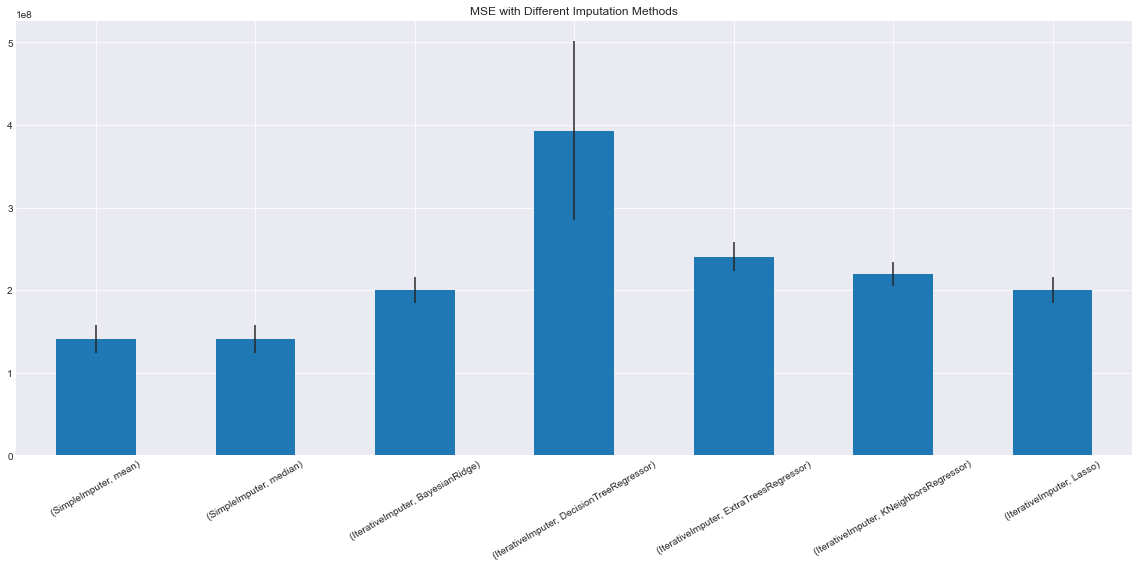



Method with Minimum Error ('IterativeImputer', 'KNeighborsRegressor')


In [34]:
#ploting the graphs of scores each method
scores = pd.concat(
    [score_simple_imputer, score_iterative_imputer],
    keys=['SimpleImputer', 'IterativeImputer'], axis=1
)
fig, ax =plt.subplots(1,figsize=(20, 8))
means = -scores.mean()
errors = scores.std()
means.plot(kind="bar", yerr=errors)
plt.xticks(rotation=30)
plt.title("MSE with Different Imputation Methods")
plt.show()

print("\n\nMethod with Minimum Error", errors.idxmin())
name = errors.idxmin()

### Select Estimator for filling missing values

In [35]:
selected_est =  estimators[3]
print(selected_est)    

KNeighborsRegressor(n_jobs=10, n_neighbors=10)


### Fill missing values for Numerical Atrributes

In [36]:
df_sel.isnull().sum()[num_attr]

year           0
odometer       0
lat         6814
long        6814
dtype: int64

In [37]:
df_num=df_sel[num_attr]
imputer=IterativeImputer(selected_est) 
imputed_data=imputer.fit_transform(df_num)
df_sel[num_attr]=imputed_data

In [38]:
df_sel.isnull().sum()[num_attr]

year        0
odometer    0
lat         0
long        0
dtype: int64

### Fill missing values for Categorical Atrributes

In [39]:
df_sel.isnull().sum()[cat_attr]

region               0
manufacturer      9100
model             2062
condition       147846
cylinders            0
fuel              2303
title_status      1607
transmission      1580
drive            89340
size_           253811
paint_color      93644
state                0
type             64791
dtype: int64

In [40]:
# encode categorical columns to numbers
for catFeature in cat_attr:
    labelEncode(df_sel[catFeature])
    
# Fill missing values
df_cat=df_sel[cat_attr]
imputer=IterativeImputer(selected_est) 
imputed_data=imputer.fit_transform(df_cat)
df_sel[cat_attr]=imputed_data

/home/sanjay/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/sanjay/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/sanjay/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:669: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


In [41]:
df_sel.isnull().sum()[cat_attr]

region          0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
title_status    0
transmission    0
drive           0
size_           0
paint_color     0
state           0
type            0
dtype: int64

In [42]:
df_sel.region = pd.Categorical(df_sel.region)
df_sel.year = pd.Categorical(df_sel.year)
df_sel.manufacturer = pd.Categorical(df_sel.manufacturer)
df_sel.model = pd.Categorical(df_sel.model)
df_sel.condition = pd.Categorical(df_sel.condition)
df_sel.fuel = pd.Categorical(df_sel.fuel)
df_sel.title_status = pd.Categorical(df_sel.title_status)
df_sel.transmission = pd.Categorical(df_sel.transmission)
df_sel.drive = pd.Categorical(df_sel.drive)
df_sel.size_ = pd.Categorical(df_sel.size_)
df_sel.type = pd.Categorical(df_sel.type)
df_sel.paint_color = pd.Categorical(df_sel.paint_color)
df_sel.state = pd.Categorical(df_sel.state, )

In [43]:
df_sel = df_sel[df_sel.year.notnull()]
df_sel["age"] = df_sel.year.apply(lambda x: int(2020-x))

In [44]:
df_sel.head()

,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size_,type,paint_color,state,lat,long,posting_date,price,age
0,16.0,2010.0,7.0,7795.0,2.0,7.0,2.0,32742.0,0.0,2.0,2.0,1.5,7.0,6.0,1.0,32.590000,-85.480000,2020-12-02T08:11:30-0600,35990,10
1,16.0,2014.0,17.0,19684.0,0.0,4.0,2.0,93600.0,0.0,0.0,1.0,1.1,9.0,5.3,1.0,32.547500,-85.468200,2020-12-02T02:11:50-0600,7500,6
2,16.0,2006.0,4.0,22466.0,2.0,6.0,2.0,87046.0,0.0,0.0,0.2,1.4,0.0,1.0,1.0,32.616807,-85.464149,2020-12-01T19:50:41-0600,4900,14
4,16.0,2005.0,12.0,11398.0,0.0,7.0,0.0,116000.0,1.0,0.0,0.0,1.0,8.0,1.0,1.0,32.547500,-85.468200,2020-12-01T12:53:56-0600,19500,15
5,16.0,2016.0,39.0,20505.0,2.0,6.0,2.0,33290.0,0.0,2.0,0.8,1.4,8.0,8.0,1.0,32.590000,-85.480000,2020-12-01T07:27:25-0600,29590,4


### Need to replace other to something else

<AxesSubplot:xlabel='model', ylabel='count'>

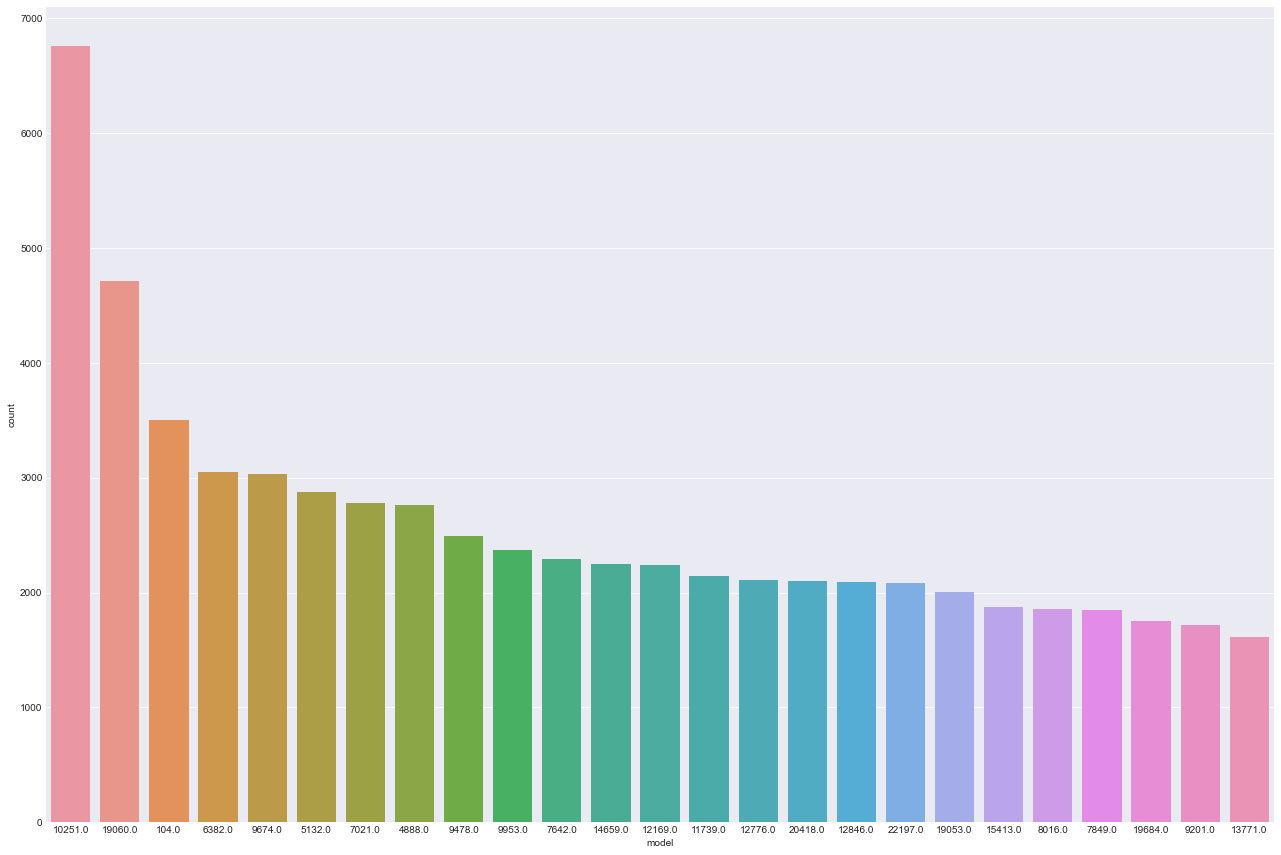

In [45]:
fig, ax =plt.subplots(1,figsize=(22, 15))
sns.countplot(x ='model', data = df_sel, order=df_sel.model.value_counts().iloc[:25].index)

<AxesSubplot:xlabel='manufacturer', ylabel='count'>

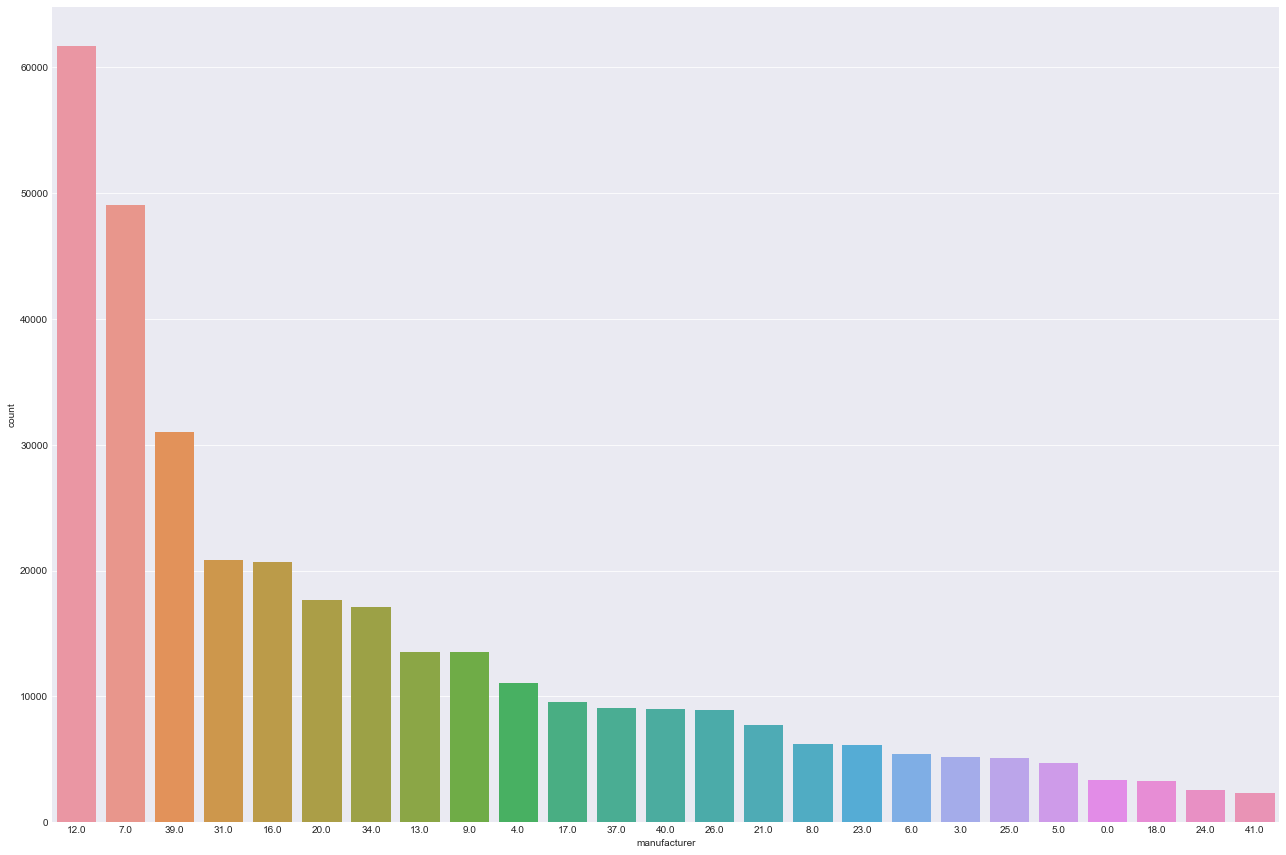

In [46]:
fig, ax =plt.subplots(1,figsize=(22, 15))
sns.countplot(x ='manufacturer',data = df_sel,order=df_sel.manufacturer.value_counts().iloc[:25].index)

<AxesSubplot:xlabel='type', ylabel='count'>

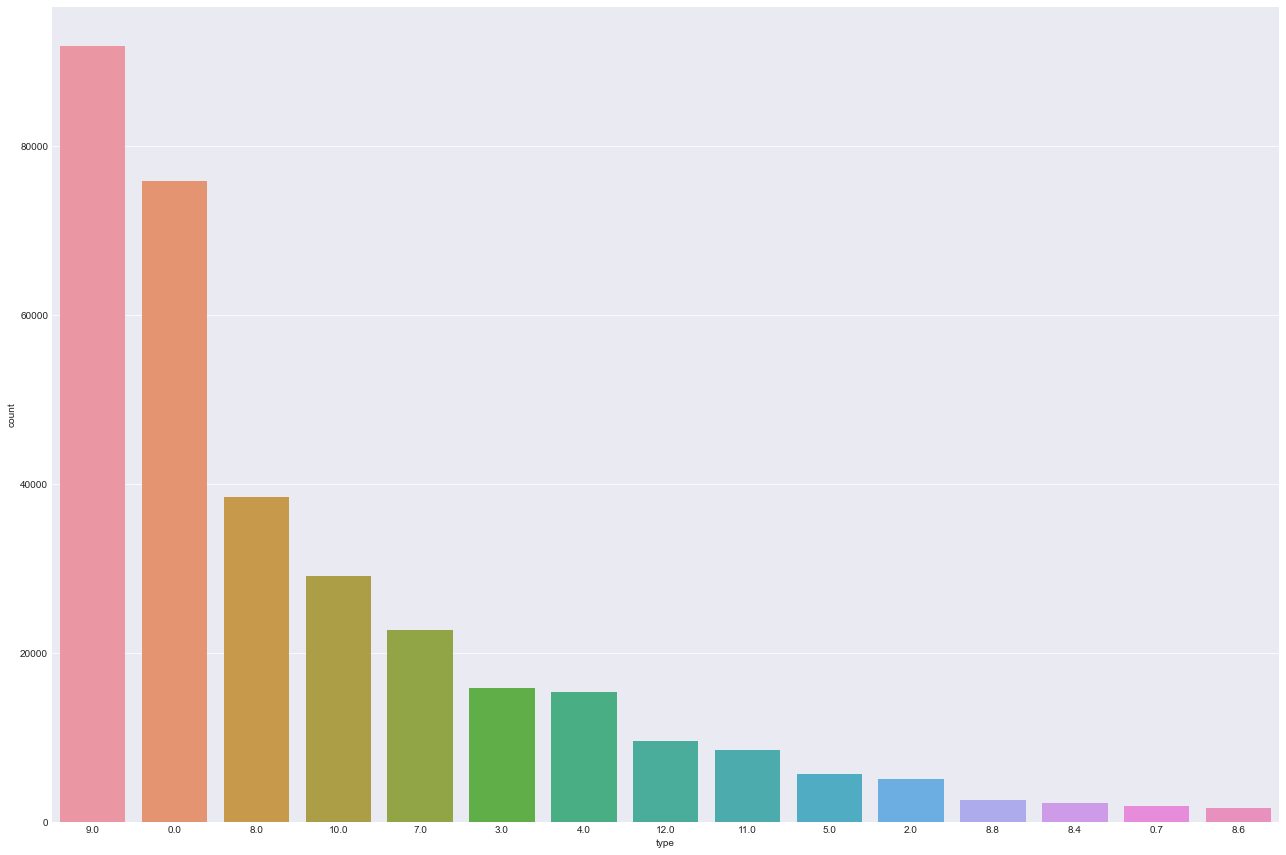

In [47]:
fig, ax =plt.subplots(1,figsize=(22, 15))
sns.countplot(x ='type',data = df_sel,order=df_sel.type.value_counts().iloc[:15].index)

In [48]:
#sns.pairplot(data = df_sel)

In [49]:
df_sel.condition.unique()
df_sel = df_sel.dropna()

In [50]:
df_sel.condition.unique()

[2.0, 0.0, 1.2, 3.0, 1.4, ..., 3.6, 3.1, 3.2, 3.3, 3.5]
Length: 40
Categories (40, float64): [2.0, 0.0, 1.2, 3.0, ..., 3.1, 3.2, 3.3, 3.5]

In [51]:
df_dummies = pd.get_dummies(df_sel.condition)

In [52]:
df_condition = pd.concat([df_sel.price, df_dummies], axis=1)
df_condition

,price,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,3.0,3.1,3.2,3.3,3.4,3.5,3.6,3.8,4.0,5.0
0,35990,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7500,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4900,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,19500,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,29590,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458208,14995,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
458209,17895,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
458210,17900,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
458211,1300,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
df_condition.corr()

,price,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,3.0,3.1,3.2,3.3,3.4,3.5,3.6,3.8,4.0,5.0
price,1.000000,-0.107886,0.004345,0.011020,0.015594,-0.001563,0.008129,-0.000633,0.001071,-0.004834,...,0.018301,-0.000986,0.004301,0.000148,0.000810,-0.001490,-0.001011,0.003390,0.024475,-0.024357
0.0,-0.107886,1.000000,-0.019458,-0.075869,-0.056027,-0.088423,-0.077900,-0.102362,-0.089924,-0.110763,...,-0.148934,-0.002860,-0.003197,-0.001011,-0.004044,-0.001011,-0.002477,-0.003783,-0.030420,-0.017723
0.1,0.004345,-0.019458,1.000000,-0.003970,-0.002932,-0.004627,-0.004076,-0.005356,-0.004705,-0.005796,...,-0.007793,-0.000150,-0.000167,-0.000053,-0.000212,-0.000053,-0.000130,-0.000198,-0.001592,-0.000927
0.2,0.011020,-0.075869,-0.003970,1.000000,-0.011430,-0.018040,-0.015893,-0.020884,-0.018346,-0.022597,...,-0.030385,-0.000583,-0.000652,-0.000206,-0.000825,-0.000206,-0.000505,-0.000772,-0.006206,-0.003616
0.3,0.015594,-0.056027,-0.002932,-0.011430,1.000000,-0.013322,-0.011736,-0.015422,-0.013548,-0.016688,...,-0.022438,-0.000431,-0.000482,-0.000152,-0.000609,-0.000152,-0.000373,-0.000570,-0.004583,-0.002670
0.4,-0.001563,-0.088423,-0.004627,-0.018040,-0.013322,1.000000,-0.018523,-0.024339,-0.021382,-0.026337,...,-0.035413,-0.000680,-0.000760,-0.000240,-0.000962,-0.000240,-0.000589,-0.000900,-0.007233,-0.004214
0.5,0.008129,-0.077900,-0.004076,-0.015893,-0.011736,-0.018523,1.000000,-0.021443,-0.018837,-0.023202,...,-0.031198,-0.000599,-0.000670,-0.000212,-0.000847,-0.000212,-0.000519,-0.000792,-0.006372,-0.003713
0.6,-0.000633,-0.102362,-0.005356,-0.020884,-0.015422,-0.024339,-0.021443,1.000000,-0.024752,-0.030488,...,-0.040995,-0.000787,-0.000880,-0.000278,-0.001113,-0.000278,-0.000682,-0.001041,-0.008373,-0.004878
0.7,0.001071,-0.089924,-0.004705,-0.018346,-0.013548,-0.021382,-0.018837,-0.024752,1.000000,-0.026784,...,-0.036014,-0.000692,-0.000773,-0.000244,-0.000978,-0.000244,-0.000599,-0.000915,-0.007356,-0.004286
0.8,-0.004834,-0.110763,-0.005796,-0.022597,-0.016688,-0.026337,-0.023202,-0.030488,-0.026784,1.000000,...,-0.044359,-0.000852,-0.000952,-0.000301,-0.001205,-0.000301,-0.000738,-0.001127,-0.009061,-0.005279


In [54]:
from scipy.stats import pointbiserialr
from scipy.stats import kruskal
from scipy.stats import f_oneway
print(pointbiserialr(df_condition.price, df_condition.excellent))
print(kruskal(df_condition.price, df_condition.excellent))
print(f_oneway(df_condition.price, df_condition.excellent))

AttributeError: 'DataFrame' object has no attribute 'excellent'